# Testing Unif(0,1) Random Number Generators

## Abstract
Simulations of a system in which there are intrinsically random elements require a method of generating or accessing numbers that are random. For example, if you wanted to simulate a queuing model, you might need to obtain random interarrival and service times that are drawn from a specified probability distribution such as an exponential distribution. This is where the **uniform distribution** on the interval [0,1] comes into play: random variates from all other distributions, such as Erlang, normal, triangular, and realizations of various random processes can be obtained by **transforming** independent and identically distributed (IID) random Unif(0,1) numbers that are spawned from random number generators (RNGs). Thus, these random numbers created in computer simulation software are actually **deterministic**, and we can only believe that they *appear* as if they were truly IID Unif(0,1).

## Background and Description of Problem
For this project, I will conduct some empirical tests to assess how closely the random numbers generated from various popular RNGs resemble truly IID Unif(0,1). I have chosen 3 criteria that will be assessed for a “good enough” RNG. A good RNG, at a **bare minimum**, should have the following traits:

>**<font size="4">1. Can generate values that are i.i.d. Unif(0,1)</font>** <br>
**<font size="4">2. Very fast </font>** <br>
**<font size="4">3. Reproducible </font>** <br>


I have selected 3 RNGs: **RANDU, Desert Island, and L'ecuyer Combined Generator**, and will assess criteria (1) for each of them. After that, I will discuss criteria (2) and (3). But first let's import all the necessary libraries needed to conduct the relevant analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import time
from scipy import stats
from statsmodels.sandbox.stats.runs import runstest_1samp

### Linear Congruential Generators

Most of the RNGs used today are **Linear Congruential Generators** (LCG) where a sequence Z<sub>1</sub>, Z<sub>2</sub> , ... is defined by the recursive formula: <br>
> **Z<sub>i</sub> = (aZ<sub>i-1</sub> + c)(mod m)** <br> 

where m (the modulus), a (the multiplier), c (the increment), and Z<sub>0</sub> (the seed) are nonnegative integers. Simply put, in order to obtain Z<sub>i</sub>, divide aZ<sub>i-1</sub> + c by m and let Z<sub>i</sub> be the remainder of this division. So, 0  $\le$ Z<sub>i</sub> $\le$  m - 1, and to obtain the desired random numbers U<sub>i</sub> (for i = 1, 2, . . . ) on [0, 1], we let U<sub>i</sub> = Z<sub>i</sub>/m. Thus, we must **carefully choose a, c, m, and Z<sub>i</sub>** to yield an LCG that generates random numbers that appear to be IID Unif(0,1). <br><br> It's also worth mentioning that there is a **looping** mechanism: whenever Z<sub>i</sub> takes on a value it previously had, the same sequence of values will be generated and the cycle endlessly repeats, and the length of this cycle is called a **period**. An LCG has a **full period** if its period is equal to m. Having a full (or at least a long) period is a beneficial property of an LCG. <br><br> I have defined a function below that implements the LCG formula and takes in parameters: **m, a, and the number of random numbers to generate**. Notice how I didn't include **c**. This is because the LCGs that I am focusing on (RANDU and Desert Island) simply do not have a ***c*** parameter(these are special types of LCGs called **multiplicative LCGs**)

In [2]:
def linear_congruential_generator(m, a, n_random_nums):
    import random
    #begin sequence
    t0 = time.time()
    
    #initialize the stream with a random seed, with a 5 digit number
    X0 = random.randint(10000,99999)
    
    #initialize the generator by creating an array of zeros
    X = np.zeros(n_random_nums)
    
    #initialize the array to store the PRNs
    R = np.zeros(n_random_nums)
    
    #Set the first element to be the seed
    X[0] = X0
    
    #Loop through the number of random numbers and implement LCG formula
    for i in range(1, n_random_nums):
        X[i] = ((X[i-1] * a)) % m
        R[i] = X[i] / m
        
    #end sequence
    t1 = time.time()
    
    #define efficiency as the number of PRNs generated divided by the length of time
    efficiency = n_random_nums/(t1-t0)
    
    #return the stream of PRNs, total running time of creating a stream, as well as its efficiency
    return R[1:], t1-t0, efficiency

## Main Findings

### RANDU

The first LCG I will test is called **RANDU**, which was a widely-used LCG in the 1960s and 1970s. Its formula is: <br>
> <font size="4">Z<sub>i</sub> = (65539Z<sub>i-1</sub>)(mod 2<sup>31</sup>)</font> <br>

Today, RANDU is a poorly conceived LCG and is no longer used because it fails the **spectral test**, which is another statistical test that can be used to assess the quality of an RNG. If you were to make a 3-D plot of 100,000 numbers with RANDU, in which each point represents 3 consecutive values, all of the points fall onto 15 distinct 2-D planes. Below is the plot: 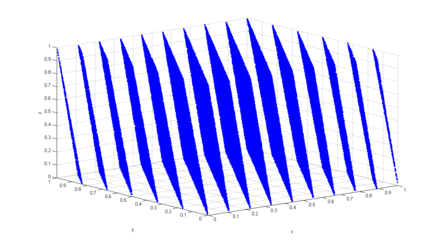 <br>
However, I wish to assess its quality via other statistical tests to see how "bad" it really is. Maybe it's not as bad as people think. Let's generate 1 million pseudorandom numbers (PRNs) using RANDU and make a histogram and see if we can visualize if they are uniformly distributed between 0 and 1.

In [16]:
RANDU = linear_congruential_generator(2**31,65539,10**6) #generate 1 million PRNs via the RANDU generator
RANDU_efficiency = RANDU[2] #calculate runtime efficiency of RANDU
RANDU_hist = np.histogram(RANDU[0], np.linspace(0,1,11)) #count how many PRNs fall into each subinterval
RANDU_hist

(array([ 99815, 100561, 100032, 100009, 100074,  99693,  99723,  99882,
        100420,  99790]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

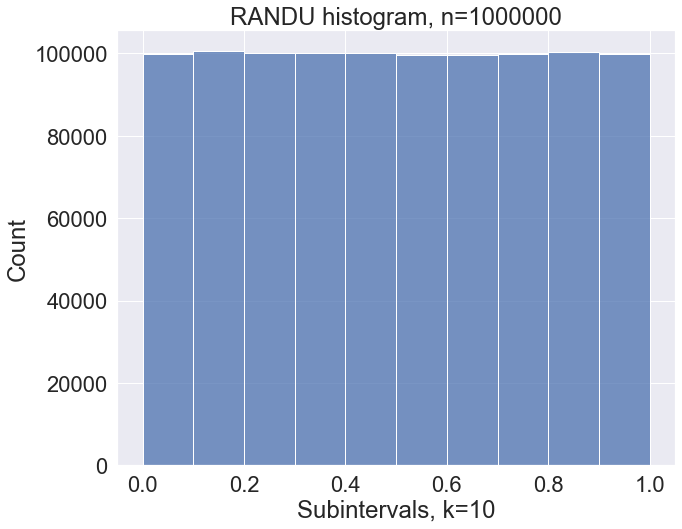

In [17]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.histplot(RANDU[0], bins=10) #count how many PRNs fall into each subinterval, k=10
plt.title("RANDU histogram, n=1000000")
plt.xlabel('Subintervals, k=10')
plt.show()

Above is a histogram that counts how many of the 1 million psuedorandom numbers are in each subinterval. For the sake of simplicity, I have selected **10 equal-probable subintervals, k=10**. Thus, with 1 million PRNs and 10 subintervals, we would expect that the probability that an observation would fall into subinterval i is **$\frac{1}{10}$**, with each bin ranging from [0, $\frac{1}{10}$), [$\frac{1}{10}$, $\frac{2}{10}$), . . . , [$\frac{9}{10}$, 1]. Below is a dataframe that compares the actual number of observations vs the expected number of observations that fall into each subinterval.

In [18]:
begin = RANDU_hist[1][:-1]
end = RANDU_hist[1][1:]
begin, end

begin_round = [round(i, 2) for i in begin]
end_round = [round(i, 2) for i in end]

subintervals = []
for i, j in zip(begin_round, end_round):
    subinterval = "[" + str(i) + ", " + str(j) + ")"
    subintervals.append(subinterval)

RANDU_obs = pd.DataFrame(RANDU_hist[0], index=subintervals)
RANDU_obs['Expected Number of Observations'] = 100000
RANDU_obs = RANDU_obs.rename(columns={0:"Actual Number of Observations"})
RANDU_obs

,Actual Number of Observations,Expected Number of Observations
"[0.0, 0.1)",99815,100000
"[0.1, 0.2)",100561,100000
"[0.2, 0.3)",100032,100000
"[0.3, 0.4)",100009,100000
"[0.4, 0.5)",100074,100000
"[0.5, 0.6)",99693,100000
"[0.6, 0.7)",99723,100000
"[0.7, 0.8)",99882,100000
"[0.8, 0.9)",100420,100000
"[0.9, 1.0)",99790,100000


At first glance, these observations appear to be uniformly distributed between 0 and 1. But how do we know for sure? Fortunately, we can conduct **two types of empirical tests** to statistically examine how closely they resemble true IID Unif (0,1) numbers, which is assessing the first criteria aforementioned (1).

### Empirical Tests (Testing Criteria (1))

#### Chisquared Goodness of Fit

The first type of empirical test is a chisquared goodness-of-fit test, which will be used to determine if the PRNs generated appear to be uniformly distributed between 0 and 1. Here's the formal test setup:
>**<font size="4">H<sub>0</sub>: R<sub>1</sub>, R<sub>2</sub>, ...R<sub>n</sub> ~ Unif(0,1)</font>** <br>
>**<font size="4">H<sub>0</sub>: R<sub>1</sub>, R<sub>2</sub>, ...R<sub>n</sub> *are not* Unif(0,1)</font>** <br>

We consider the null hypothesis as the status quo, so we’ll only reject the null if there's sufficient evidence against it. (Innocent until proven guilty.) That is, the null hypothesis assumes that the PRNs resemble true Unif(0,1)s. I will set the ***level of significance***, **$\alpha $ =  P(RejectH0|H0 true) = P(Type I error) = 0.05** <br>

1. Divide [0,1] into k subintervals. If you choose equi-probable cells [0, $\frac{1}{k}$), [$\frac{1}{k}$, $\frac{2}{k}$), . . . , [$\frac{k-1}{k}$), 1], then a particular observation R<sub>i</sub> will fall in a particular cell with probability $\frac{1}{k}$. <br> <br>

2. Tally how many of the n observations fall into the k cells. If O<sub>i</sub> = the # of R<sub>j</sub>’s in subinterval i, then (since the R<sub>j</sub>’s are i.i.d.), we can easily see that
><font size="4">O<sub>i</sub> ∼ Bin(n, $\frac{1}{k}$), i = 1,2,...,k.</font> <br> <br>

3. Thus, the expected number of R<sub>j</sub>’s to fall in subinterval i will be <font size="4">E<sub>i</sub> = E[O<sub>i</sub>] = $\frac{n}{k}$, i = 1,2,...,k.</font> <br>



#### Runs Test

The second type of empirical test is a runs test, which is used to determine if a dataset comes from a random process or if it follows a pattern by considering runs of data. This directly tests the ***independence and identically distributed assumption*** from criteria (1). A run is defined as a sequence of increasing or decreasing values, and the number of increasing or decreasing values is the length of a run. There are various ways of defining a positive and negative runs but for our purposes, any value that is **greater than the mean (> 0.50)** is a *positive* value and any value that is **less than the mean (<0.50)** is a *negative* value. Here's the formal test setup: <br>
>**<font size="4">H<sub>0</sub>: The data was produced in a random manner </font>** <br>
>**<font size="4">H<sub>a</sub>: The data was *not* produced in a random manner </font>** <br>

Again, we consider the null hypothesis as the status quo, so we’ll only reject the null if there's sufficient evidence against it. That is, the null hypothesis assumes that the PRNs were generated in a random manner. I will set the *level of significance*, **$\alpha $ =  P(RejectH0|H0 true) = P(Type I error) = 0.05** <br>

### Testing RANDU

Now it's time to apply these two tests on RANDU. Also, I wish to see how the number of subintervals for the chisquared goodness of fit test affects the test statistic. For example, will we draw different conclusions for **10 subintervals vs 100 subintervals vs 1000 subintervals**? <br>
>**Note #1**: I will basically conduct a chisquared goodness of fit test and runs test **3 times each, one for each number of subintervals of 10, 100, 1000**.  Because the number of subintervals has nothing to do with the runs test statistic, I predict that there won't be any noticeable differences among the various number of subintervals. <br>

>**Note #2:** For each number of subintervals (10, 100, 1000), I will conduct a chisquared goodness of fit test **100 times** and a runs test **100 times**, and use the **average** of their test statistics along with the corresponding p-values. Even if RANDU appears to be "good", the p-value will be below the level of significance, 0.05, in about 5% of my test. Thus, I believe it's necessary to do as many trials as possible before making any conclusions

In [10]:
from statistics import mean

num_cells = [10, 100, 1000] #number of subintervals

chisquare_critical_values = [] #chi2 critical values for each c in num_cells

average_chisquare_test_statistics = [] #average chi2 test statistic for each c after 100 iterations

average_p_chisquare = [] #average chi2 p-value for each c after 100 iterations

runs_critical_values = [] #runs test critical values for each c in num_cells

average_runs_test_statistics = [] #average runs test statistic for each c after 100 iterations

average_p_runs = [] #average runs test p-value for each c after 100 iterations

for c in num_cells:

    raw = [linear_congruential_generator(2**31, 65539, 1000000)[0] for i in range(100)]

    observed = [np.histogram(i, bins=np.linspace(0,1,c+1))[0] for i in raw]

    expected = np.array([1000000/c]*c)
    
    cv_chi2 = stats.chi2.ppf(.95, df=c-1)
    
    chisquare_critical_values.append(cv_chi2)
    
    mean_chi2_test_statistic = mean([stats.chisquare(i, expected)[0] for i in observed])
    
    average_chisquare_test_statistics.append(mean_chi2_test_statistic)

    mean_chi2_p = mean([stats.chisquare(i, expected)[1] for i in observed])
    
    average_p_chisquare.append(mean_chi2_p)
    
    cv_norm = stats.norm.ppf(1-.05/2)
    
    runs_critical_values.append(cv_norm)
    
    mean_runs_test_statistic = mean([runstest_1samp(i, correction=False)[0] for i in raw])
    
    average_runs_test_statistics.append(mean_runs_test_statistic)
    
    mean_runs_p = mean([runstest_1samp(i, correction=False)[1] for i in raw])
    
    average_p_runs.append(mean_runs_p)
    
    
chisquare_critical_values, average_chisquare_test_statistics, average_p_chisquare, runs_critical_values, average_runs_test_statistics, average_p_runs

([16.918977604620448, 123.2252214533618, 1073.6426506574246],
 [8.5321778, 98.230352, 992.14576],
 [0.5298480450825237, 0.5099291046432817, 0.5293714588404066],
 [1.959963984540054, 1.959963984540054, 1.959963984540054],
 [-0.05730595725409898, -0.02992108375102189, 0.07367537695465295],
 [0.47690899813332244, 0.5410784267067206, 0.5059575923736034])

In [15]:
#dictionary containing statistical test results for RANDU
d_RANDU = {'Chisquare Critical Value': chisquare_critical_values,
    'Chisquare Test Statistic': average_chisquare_test_statistics,
    'Chisquare p-value': average_p_chisquare,
    'Reject Chisquare GOF test?': ['Fail to reject', 'Fail to reject', 'Fail to reject'],
    'Runs Test Critical Value': runs_critical_values,
    'Runs Test Statistic': average_runs_test_statistics,
    'Runs p-value': average_p_runs,
    'Reject Runs Test for Independence?': ['Fail to reject', 'Fail to reject', 'Fail to reject']}


#create a df from the dictionary
RANDU_df = pd.DataFrame(data=d_RANDU, index=num_cells)
RANDU_df.index.name = 'Number of Cells'
RANDU_df

,Chisquare Critical Value,Chisquare Test Statistic,Chisquare p-value,Reject Chisquare GOF test?,Runs Test Critical Value,Runs Test Statistic,Runs p-value,Reject Runs Test for Independence?
Number of Cells,,,,,,,,
10,16.918978,8.532178,0.529848,Fail to reject,1.959964,-0.057306,0.476909,Fail to reject
100,123.225221,98.230352,0.509929,Fail to reject,1.959964,-0.029921,0.541078,Fail to reject
1000,1073.642651,992.145760,0.529371,Fail to reject,1.959964,0.073675,0.505958,Fail to reject


### RANDU Test Results
#### Chisquared Goodness of Fit
The relevant chisquared critical values for k = [10, 100, 1000] are (16.9190, 123.2252, 1073.6427) and the corresponding chisquared test statistics and p-values are (8.5322, 98.2304, 992.1458) and (0.5298, 0.5099, 0.5294), respectively. Since all of chisquared test statistics are less than the critical values and the p-values are greater than 0.05, we **fail to reject the null hypothesis** and have sufficient evidence that the PRNs generated from RANDU are uniformly distributed between 0 and 1.

#### Runs Test for Independence
The relevant runs test critical value for k = [10, 100, 1000] is 1.96 and the corresponding runs test statistics and p-values are (-0.0573, -0.0299, 0.0737) and (0.4769, 0.5410, 0.5060), respectively. Since all of the absolute value of the runs test statistics are less than the critical values and the p-values are greater than 0.05, we **fail to reject the null hypothesis** and have sufficient evidence that the PRNs generated from RANDU were produced in a random manner and are independent.

#### Conclusion
RANDU passed both empirical tests so we can safely say that it satisfies criteria (1) in that RANDU can generate values that are IID Unif(0,1). Notice how the average p-value for each number of subintervals is around 0.50 for both the chisquared goodness of fit test **and** the runs test, which effectively nullifies any Type 1 errors. Also, it seems as though the number of subintervals don't really matter. Could this be a coincidence? Maybe.

### Desert Island

The second LCG I will test is called **Desert Island**. Its formula is: <br>
> <font size="4">Z<sub>i</sub> = (16807Z<sub>i-1</sub>)(mod 2<sup>31</sup>-1)</font> <br>

It's full period and its cycle length is > 2 billion. Let's generate 1 million of these.

In [21]:
desert_island = linear_congruential_generator(2**31-1,16807,10**6) #generate 1 million PRNs via the RANDU generator
desert_island_efficiency = desert_island[2] #calculate runtime efficiency of RANDU
desert_island_hist = np.histogram(desert_island[0], np.linspace(0,1,11)) #count how many PRNs fall into each subinterval
desert_island_hist

(array([ 99866, 100197, 100217,  99577, 100058,  99684, 100134,  99708,
        100259, 100299]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

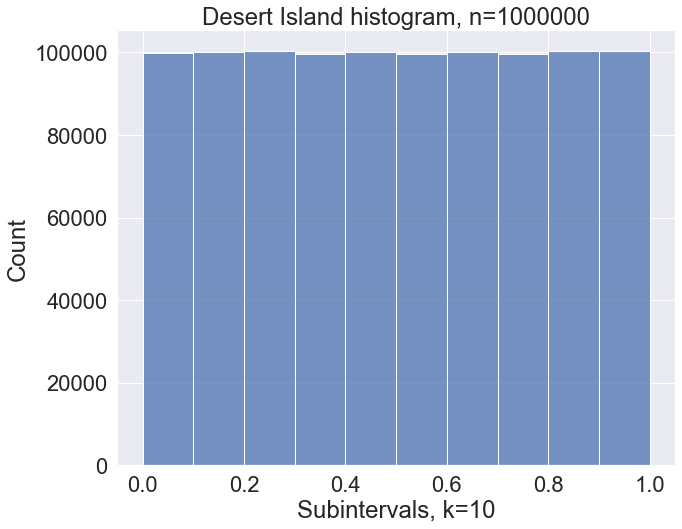

In [22]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.histplot(desert_island[0], bins=10) #count how many PRNs fall into each subinterval, k=10
plt.title("Desert Island histogram, n=1000000")
plt.xlabel('Subintervals, k=10')
plt.show()

In [25]:
begin = desert_island_hist[1][:-1]
end = desert_island_hist[1][1:]
begin, end

begin_round = [round(i, 2) for i in begin]
end_round = [round(i, 2) for i in end]

subintervals = []
for i, j in zip(begin_round, end_round):
    subinterval = "[" + str(i) + ", " + str(j) + ")"
    subintervals.append(subinterval)

desert_island_obs = pd.DataFrame(desert_island_hist[0], index=subintervals)
desert_island_obs['Expected Number of Observations'] = 100000
desert_island_obs = desert_island_obs.rename(columns={0:"Actual Number of Observations"})
desert_island_obs

,Actual Number of Observations,Expected Number of Observations
"[0.0, 0.1)",99866,100000
"[0.1, 0.2)",100197,100000
"[0.2, 0.3)",100217,100000
"[0.3, 0.4)",99577,100000
"[0.4, 0.5)",100058,100000
"[0.5, 0.6)",99684,100000
"[0.6, 0.7)",100134,100000
"[0.7, 0.8)",99708,100000
"[0.8, 0.9)",100259,100000
"[0.9, 1.0)",100299,100000


Similar to RANDU, these observations ***appear*** to be uniformly distributed between 0 and 1, but we don't know for sure. Thus, let's conduct the same empirical tests (with the exactly the same test setup) to assess the first criteria (1).

### Testing Desert Island

In [26]:
num_cells = [10, 100, 1000] #number of subintervals

chisquare_critical_values = [] #chi2 critical values for each c in num_cells

average_chisquare_test_statistics = [] #average chi2 test statistic for each c after 100 iterations

average_p_chisquare = [] #average chi2 p-value for each c after 100 iterations

runs_critical_values = [] #runs test critical values for each c in num_cells

average_runs_test_statistics = [] #average runs test statistic for each c after 100 iterations

average_p_runs = [] #average runs test p-value for each c after 100 iterations

for c in num_cells:

    raw = [linear_congruential_generator(2**31-1, 16807, 1000000)[0] for i in range(100)]

    observed = [np.histogram(i, bins=np.linspace(0,1,c+1))[0] for i in raw]

    expected = np.array([1000000/c]*c)
    
    cv_chi2 = stats.chi2.ppf(.95, df=c-1)
    
    chisquare_critical_values.append(cv_chi2)
    
    mean_chi2_test_statistic = mean([stats.chisquare(i, expected)[0] for i in observed])
    
    average_chisquare_test_statistics.append(mean_chi2_test_statistic)

    mean_chi2_p = mean([stats.chisquare(i, expected)[1] for i in observed])
    
    average_p_chisquare.append(mean_chi2_p)
    
    cv_norm = stats.norm.ppf(1-.05/2)
    
    runs_critical_values.append(cv_norm)
    
    mean_runs_test_statistic = mean([runstest_1samp(i, correction=False)[0] for i in raw])
    
    average_runs_test_statistics.append(mean_runs_test_statistic)
    
    mean_runs_p = mean([runstest_1samp(i, correction=False)[1] for i in raw])
    
    average_p_runs.append(mean_runs_p)
    
    
chisquare_critical_values, average_chisquare_test_statistics, average_p_chisquare, runs_critical_values, average_runs_test_statistics, average_p_runs

([16.918977604620448, 123.2252214533618, 1073.6426506574246],
 [8.7265416, 97.55815, 998.23402],
 [0.5185148880278332, 0.5454799734336656, 0.4936099039759865],
 [1.959963984540054, 1.959963984540054, 1.959963984540054],
 [-0.019235237967202782, -0.034885881672065175, 0.04966785338682607],
 [0.46499645061596506, 0.5285156017970069, 0.39995286872297836])

In [27]:
#dictionary containing statistical test results for desert island
d_desert_island = {'Chisquare Critical Value': chisquare_critical_values,
    'Chisquare Test Statistic': average_chisquare_test_statistics,
    'Chisquare p-value': average_p_chisquare,
    'Reject Chisquare GOF test?': ['Fail to reject', 'Fail to reject', 'Fail to reject'],
    'Runs Test Critical Value': runs_critical_values,
    'Runs Test Statistic': average_runs_test_statistics,
    'Runs p-value': average_p_runs,
    'Reject Runs Test for Independence?': ['Fail to reject', 'Fail to reject', 'Fail to reject']}


#create a df from the dictionary
desert_island_df = pd.DataFrame(data=d_desert_island, index=num_cells)
desert_island_df.index.name = 'Number of Cells'
desert_island_df

,Chisquare Critical Value,Chisquare Test Statistic,Chisquare p-value,Reject Chisquare GOF test?,Runs Test Critical Value,Runs Test Statistic,Runs p-value,Reject Runs Test for Independence?
Number of Cells,,,,,,,,
10,16.918978,8.726542,0.518515,Fail to reject,1.959964,-0.019235,0.464996,Fail to reject
100,123.225221,97.558150,0.545480,Fail to reject,1.959964,-0.034886,0.528516,Fail to reject
1000,1073.642651,998.234020,0.493610,Fail to reject,1.959964,0.049668,0.399953,Fail to reject


### Desert Island Test Results
#### Chisquared Goodness of Fit
The relevant chisquared critical values for k = [10, 100, 1000] are (16.9190, 123.2252, 1073.6427) and the corresponding chisquared test statistics and p-values are (8.7265, 97.5582, 998.2340) and (0.5185, 0.5455, 0.4936), respectively. Since all of chisquared test statistics are less than the critical values and the p-values are greater than 0.05, we **fail to reject the null hypothesis** and have sufficient evidence that the PRNs generated from Desert Island are uniformly distributed between 0 and 1.

#### Runs Test for Independence
The relevant runs test critical value for k = [10, 100, 1000] is 1.96 and the corresponding runs test statistics and p-values are (-0.0192, -0.0348, 0.0497) and (0.4650, 0.5285, 0.400), respectively. Since all of the absolute value of the runs test statistics are less than the critical values and the p-values are greater than 0.05, we **fail to reject the null hypothesis** and have sufficient evidence that the PRNs generated from Desert Island were produced in a random manner and are independent.

#### Conclusion
Desert Island passed both empirical tests so we can safely say that it satisfies criteria (1) in that Desert Island can generate values that are IID Unif(0,1). Similar to RANDU, notice how the average p-value for each number of subintervals is around 0.50 for both the chisquared goodness of fit test **and** the runs test, which effectively nullifies any Type 1 errors. Could this be a coincidence? Maybe.

### L'ecuyer Combined Generator

One interesting feature of LCG's is that you can combine them to create a more robust LCG, as mathematician Pierre L'ecuyer did in 1999. In simplified form, the idea is to let Z<sub>1i</sub> and Z<sub>2i</sub> denote the integer sequences generated by two different LCGs with different moduli, then let Z<sub>i</sub> = (Z<sub>1i</sub> -  Z<sub>2i</sub>)(mod m) for some integer m, and finally set U<sub>i</sub> = Z<sub>i</sub>/m. It has a cycle length of about 2<sup>191</sup>. Here's the official formula: <br>

><font size="4">Initialize X<sub>1,0</sub> X<sub>1,1</sub>, X<sub>1,2</sub>, X<sub>2,0</sub>, X<sub>2,1</sub>, X<sub>2,2</sub>. For i ≥ 3, set</font> <br> <br>
<font size="4">X<sub>1,i</sub> = (1,403,580X<sub>1,i-2</sub> − 810,728X<sub>1,i-3</sub>)mod(2<sup>32</sup> − 209)</font><br> <br>
<font size="4">X<sub>2,i</sub> = (527,612X<sub>2,i-1</sub> − 1,370,589X<sub>2,i-3</sub>)mod(2<sup>32</sup> − 22,853)</font> <br> <br>
<font size="4">Y<sub>i</sub> = (X<sub>1,i</sub> − X<sub>2,i</sub>)mod(2<sup>32</sup> − 209)</font> <br> <br>
<font size="4">R<sub>i</sub> = Y<sub>i</sub>/(2<sup>32</sup> − 209) <br>
 
I have defined a function below that implements the L'ecuyer formula and it only takes in one parameter: number of random numbers to generate. Also, note that running the function always yields a different initialization of 6, 5 digit numbers. Let's generate 1 million of these.

In [28]:
def combined_generator(n_random_nums): # 
    import random
    #begin sequence
    t0 = time.time()
    
    #initialize the stream with 6 random seeds, all of whom are a 5 digit number
    X10, X11, X12, X20, X21, X22 = [random.randint(10000,99999) for i in range(6)]
    
    #initialize the generator by creating an array of zeros
    initial_X1 = np.array([X10, X11, X12])
    initial_X2 = np.array([X20, X21, X22])
    
    zeros = np.zeros(n_random_nums)
    
    X_1 = np.concatenate((initial_X1, zeros))
    X_2 = np.concatenate((initial_X2, zeros))
    
    #implement L'ecuyer
    for i in range(3, len(X_1)):
        X_1[i] = (1403580*(X_1[i-2]) - 810728*(X_1[i-3])) % (2**32 - 209)
        
    for i in range(3, len(X_2)):
        X_2[i] = (527612*(X_2[i-1]) - 1370589*(X_2[i-3])) % (2**32 - 22853)
        
    Y = (X_1 - X_2) % (2**32 - 209)
    
    R = Y / (2**32 - 209)
    
    #end sequence
    t1 = time.time()
    
    #define efficiency as the number of PRNs generated divided by the length of time
    efficiency = n_random_nums/(t1-t0)
    
    #return the 3 arrays used to make the stream of PRNs, total running time to generate a stream, and its efficiency
    return X_1, X_2, Y, R[3:], t1-t0, efficiency

In [29]:
lecuyer = combined_generator(10**6) #generate 1 million PRNs via the Lecuyer generator
lecuyer_efficiency = lecuyer[5] #calculate runtime efficiency of Lecuyer
lecuyer_hist = np.histogram(lecuyer[3], np.linspace(0,1,11)) #count how many PRNs fall into each subinterval, k=10
lecuyer_hist

(array([100119, 100041, 100277,  99863,  99549, 100090, 100141, 100212,
         99952,  99756]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

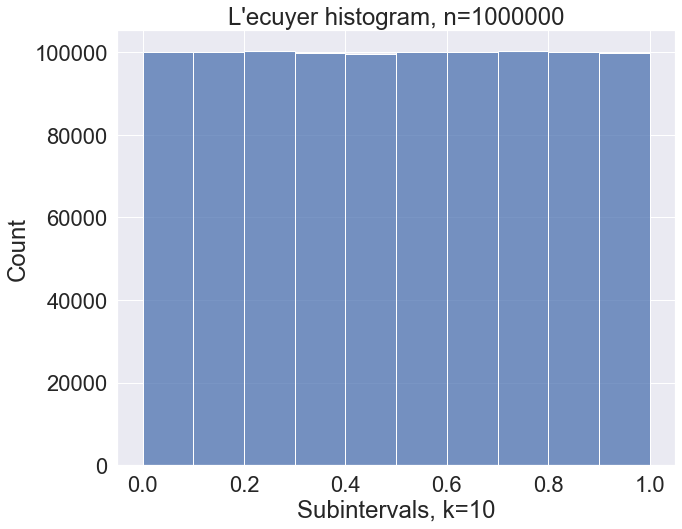

In [30]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.histplot(lecuyer[3], bins=10) #histogram of the 10 million PRNs along with their subintervals
plt.title("L'ecuyer histogram, n=1000000")
plt.xlabel('Subintervals, k=10')
plt.show()

In [31]:
begin = lecuyer_hist[1][:-1]
end = lecuyer_hist[1][1:]
begin, end

begin_round = [round(i, 2) for i in begin]
end_round = [round(i, 2) for i in end]

subintervals = []
for i, j in zip(begin_round, end_round):
    subinterval = "[" + str(i) + ", " + str(j) + ")"
    subintervals.append(subinterval)

lecuyer_obs = pd.DataFrame(lecuyer_hist[0], index=subintervals)
lecuyer_obs['Expected Number of Observations'] = 100000
lecuyer_obs = lecuyer_obs.rename(columns={0:"Actual Number of Observations"})
lecuyer_obs

,Actual Number of Observations,Expected Number of Observations
"[0.0, 0.1)",100119,100000
"[0.1, 0.2)",100041,100000
"[0.2, 0.3)",100277,100000
"[0.3, 0.4)",99863,100000
"[0.4, 0.5)",99549,100000
"[0.5, 0.6)",100090,100000
"[0.6, 0.7)",100141,100000
"[0.7, 0.8)",100212,100000
"[0.8, 0.9)",99952,100000
"[0.9, 1.0)",99756,100000


Similar to RANDU and Desert Island, these observations ***appear*** to be uniformly distributed between 0 and 1, but we don't know for sure. Thus, let's conduct the same empirical tests (with the exactly the same test setup) to assess the first criteria (1).

In [32]:
num_cells = [10, 100, 1000] #number of subintervals

chisquare_critical_values = [] #chi2 critical values for each c in num_cells

average_chisquare_test_statistics = [] #average chi2 test statistic for each c after 100 iterations

average_p_chisquare = [] #average chi2 p-value for each c after 100 iterations

runs_critical_values = [] #runs test critical values for each c in num_cells

average_runs_test_statistics = [] #average runs test statistic for each c after 100 iterations

average_p_runs = [] #average runs test p-value for each c after 100 iterations

for c in num_cells:

    raw = [combined_generator(1000000)[3] for i in range(100)]

    observed = [np.histogram(i, bins=np.linspace(0,1,c+1))[0] for i in raw]

    expected = np.array([1000000/c]*c)
    
    cv_chi2 = stats.chi2.ppf(.95, df=c-1)
    
    chisquare_critical_values.append(cv_chi2)
    
    mean_chi2_test_statistic = mean([stats.chisquare(i, expected)[0] for i in observed])
    
    average_chisquare_test_statistics.append(mean_chi2_test_statistic)

    mean_chi2_p = mean([stats.chisquare(i, expected)[1] for i in observed])
    
    average_p_chisquare.append(mean_chi2_p)
    
    cv_norm = stats.norm.ppf(1-.05/2)
    
    runs_critical_values.append(cv_norm)
    
    mean_runs_test_statistic = mean([runstest_1samp(i, correction=False)[0] for i in raw])
    
    average_runs_test_statistics.append(mean_runs_test_statistic)
    
    mean_runs_p = mean([runstest_1samp(i, correction=False)[1] for i in raw])
    
    average_p_runs.append(mean_runs_p)
    
    
chisquare_critical_values, average_chisquare_test_statistics, average_p_chisquare, runs_critical_values, average_runs_test_statistics, average_p_runs

([16.918977604620448, 123.2252214533618, 1073.6426506574246],
 [8.808582, 100.5611, 995.30812],
 [0.5045729174954234, 0.4678762914086428, 0.523781046796118],
 [1.959963984540054, 1.959963984540054, 1.959963984540054],
 [-0.04160716037426653, 0.20553984557753532, 0.010011538157710777],
 [0.4895849674764045, 0.541421885802645, 0.47358007024593757])

In [33]:
#dictionary containing statistical test results for Lecuyer
d_lecuyer = {'Chisquare Critical Value': chisquare_critical_values,
    'Chisquare Test Statistic': average_chisquare_test_statistics,
    'Chisquare p-value': average_p_chisquare,
    'Reject Chisquare GOF test?': ['Fail to reject', 'Fail to reject', 'Fail to reject'],
    'Runs Test Critical Value': runs_critical_values,
    'Runs Test Statistic': average_runs_test_statistics,
    'Runs p-value': average_p_runs,
    'Reject Runs Test for Independence?': ['Fail to reject', 'Fail to reject', 'Fail to reject']}


#create a df using the dictionary
Lecuyer_df = pd.DataFrame(data=d_lecuyer, index=num_cells)
Lecuyer_df.index.name = 'Number of Cells'
Lecuyer_df

,Chisquare Critical Value,Chisquare Test Statistic,Chisquare p-value,Reject Chisquare GOF test?,Runs Test Critical Value,Runs Test Statistic,Runs p-value,Reject Runs Test for Independence?
Number of Cells,,,,,,,,
10,16.918978,8.808582,0.504573,Fail to reject,1.959964,-0.041607,0.489585,Fail to reject
100,123.225221,100.561100,0.467876,Fail to reject,1.959964,0.205540,0.541422,Fail to reject
1000,1073.642651,995.308120,0.523781,Fail to reject,1.959964,0.010012,0.473580,Fail to reject


### L'ecuyer Combined Generator Test Results
#### Chisquared Goodness of Fit
The relevant chisquared critical values for k = [10, 100, 1000] are (16.9190, 123.2252, 1073.6427) and the corresponding chisquared test statistics and p-values are (8.8086, 100.5611, 995.3081) and (0.5046, 0.4679, 0.5238), respectively. Since all of chisquared test statistics are less than the critical values and the p-values are greater than 0.05, we **fail to reject the null hypothesis** and have sufficient evidence that the PRNs generated from L'ecuyer are uniformly distributed between 0 and 1.

#### Runs Test for Independence
The relevant runs test critical value for k = [10, 100, 1000] is 1.96 and the corresponding runs test statistics and p-values are (-0.0416, 0.2055, 0.0100) and (0.4896, 0.5414, 0.4736), respectively. Since all of the absolute value of the runs test statistics are less than the critical values and the p-values are greater than 0.05, we **fail to reject the null hypothesis** and have sufficient evidence that the PRNs generated from L'ecuyer were produced in a random manner and are independent.

#### Conclusion
L'ecuyer passed both empirical tests so we can safely say that it satisfies criteria (1) in that L'ecuyer can generate values that are IID Unif(0,1). Similar to RANDU and Desert Island, notice how the average p-value for each number of subintervals is around 0.50 for both the chisquared goodness of fit test and the runs test, which effectively nullifies any Type 1 errors. Could this be a coincidence? Maybe.

## Runtime efficiency (Criteria 2)

Another important aspect of an RNG is its runtime efficiency. When simulating a system, not only is it critical to obtain numbers that appear to be random, but it's also beneficial to obtain a lot of them since you may require millions (or even more!) numbers at a time. Let's see how many PRNs each generator produces **per second**.

In [34]:
#compile efficiencies of generators into a list
names = ['RANDU', 'Desert Island', "L'ecuyer"]
values = [RANDU_efficiency, desert_island_efficiency, lecuyer_efficiency ]
runtime_eff_df = pd.DataFrame(values, index=names)
runtime_eff_df = runtime_eff_df.rename(columns={0: '# PRNs generated per second'})
runtime_eff_df


,# PRNs generated per second
RANDU,303369.222913
Desert Island,315960.363634
L'ecuyer,185529.680695


Text(0, 0.5, '# of PRNs generated per second')

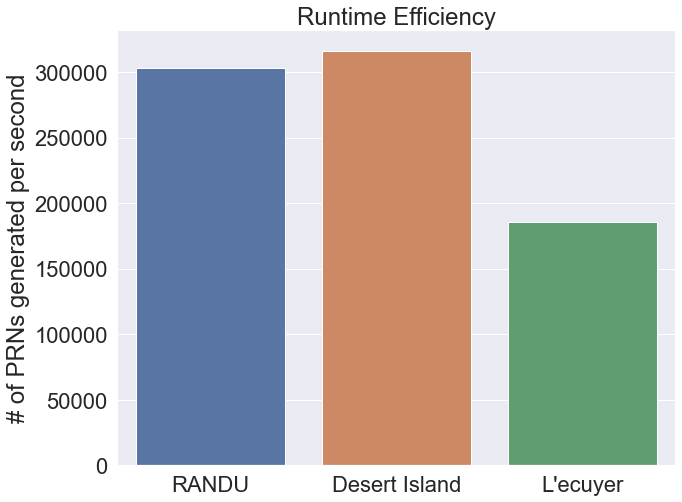

In [35]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.barplot(x=names, y=values) #create barplot comparing runtime efficiency of each generator
plt.title('Runtime Efficiency')
plt.ylabel('# of PRNs generated per second')

RANDU generated **303,369** PRNs per second, Desert Island generated **315,960** PRNs per second, and L'ecuyer generated **185,529** PRNs per second, which makes **Desert Island** the most runtime efficient of the 3. Desert Island has a slight edge over RANDU, generating **12,591** more PRNs per second, which is equivalently **4.1% faster**. It's also worth noting that L'ecuyer can only generate **a little bit more than half** as many PRNs as the other two generators. This makes sense because L'ecuyer is a combination of ***exactly 2 LCG's***. So while L'ecuyer has the longest cycle length, it is the least runtime efficient generator

## Reproducibility (Criteria 3)

We would like to reproduce any given stream of random numbers for **2 main reasons**: the first reason is that it makes **debugging** easier, and the second reason is we might want to use ***identical*** streams of numbers when simulating two different systems to get a more precise comparison. For any generator, ensuring reproducibility is simple: we only have to remember the **starting seed used prior, Z<sub>0</sub>**, and initiate the generator with this value again to obtain the same sequence of numbers.

## Conclusion

Because random numbers used in computer systems are actually completely deterministic, the best thing we can do is hope that they appear to be truly IID Unif(0,1), which can be evaluated by conducting a chisquared goodness of fit test and a runs test. RANDU, Desert Island and L'ecuyer all passed these tests with flying colors, even though RANDU fails the spectral test. I also found it really interesting how all average p-values for each generator hovered around the 0.500 mark, which teased out any Type 1 errors and suggests that the number of subintervals for the chisquared of goodness of fit test is not that important. It could be a coincidence but further analysis is needed. <br><br> Desert Island was the most efficient generator, and any stream of random numbers can be reproduced as long as the same starting seed is used. If I were to do this project again, I would choose other popular RNGs out there, such as the **Mersenne Twister**, which has an astounding cycle length of **2<sup>19937 – 1</sup>**, and use another goodness of fit test such as the **Kolmogorov–Smirnov test**.

## References

ISYE OMSA-6644: Simulation and Modeling for Engineering and Science (Dr. David Goldsman) <br><br>
Law, A. M., Simulation Modeling and Analysis, 5th edition, McGraw-Hill Education, New
York, 2015.